PCA + Neural Network Classifier with MNIST

Libraries

In [5]:
using MLDatasets           # mnist
using Images
using PreprocessingImages; pim = PreprocessingImages
using PreprocessingArrays; pa  = PreprocessingArrays

using MLJ                  # make_blobs, rmse, confmat, categorical
using MLDataUtils          # label, nlabel, labelfreq
using MLJFlux

using Metrics              # r2-score
using Random
using Plots; gr()
using StatsPlots
using DataFrames

Functions

In [6]:
# metrics
function printMetrics(ŷ, y)
    display(confmat(ŷ, y))
    println("accuracy: ", round(accuracy(ŷ, y); digits=3))
    println("f1-score: ", round(multiclass_f1score(ŷ, y); digits=3))
end


printMetrics (generic function with 1 method)

MNIST

(28, 28, 60000)

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

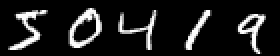

In [7]:
# load mnist
datasetX,    datasetY    = MNIST(:train)[:]
validationX, validationY = MNIST(:test)[:]

display( size(datasetX) )

img  = datasetX[:, :, 1:5]
img2 = permutedims(img, (2, 1, 3))

display(datasetY[1:5]')
mosaicview( Gray.(img2)  ; nrow=1)

In [8]:
# split trainset, testset from dataset
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((datasetX, datasetY), p = 0.7)
size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

Preprocessing

In [27]:
function preprocess(X, y)
    newX = pim.batchImage2DF(X)
    #coerce!(newX)   # no need, all scitypes are Continuous in this example
    new_y = coerce(y, OrderedFactor)
    
    return (newX, new_y)
end
using CUDA
using Flux
X_tr, y_tr = preprocess(trainX, trainY) |> gpu
# X_d = X_tr |> gpu;

In [28]:
scitype(X_tr)

Table{AbstractVector{Continuous}}

In [29]:
scitype(y_tr)

AbstractVector{OrderedFactor{10}} (alias for AbstractArray{OrderedFactor{10}, 1})

Pipe the model

In [30]:
models("PCA")[2]

(name = "PCA",
 package_name = "MultivariateStats",
 is_supervised = false,
 abstract_type = Unsupervised,
 deep_properties = (),
 docstring = "  Principal component analysis. Learns a linear tr...",
 fit_data_scitype =
     Tuple{Table{var"#s9"} where var"#s9"<:(AbstractVector{var"#s8"} where var"#s8"<:Continuous)},
 human_name = "pca",
 hyperparameter_ranges = (nothing, nothing, nothing, nothing),
 hyperparameter_types =
     ("Int64", "Symbol", "Float64", "Union{Nothing, Real, Vector{Float64}}"),
 hyperparameters = (:maxoutdim, :method, :pratio, :mean),
 implemented_methods =
     [:clean!, :fitted_params, :inverse_transform, :fit, :transform],
 inverse_transform_scitype =
     Table{var"#s9"} where var"#s9"<:(AbstractVector{var"#s8"} where var"#s8"<:Continuous),
 is_pure_julia = true,
 is_wrapper = false,
 iteration_parameter = nothing,
 load_path = "MLJMultivariateStatsInterface.PCA",
 package_license = "MIT",
 package_url = "https://github.com/JuliaStats/MultivariateStats.jl",
 p

In [31]:
# reduce predictors
PCA = @load PCA pkg=MultivariateStats verbosity=0
reducer = PCA(pratio = 0.95)

PCA(
  maxoutdim = 0, 
  method = :auto, 
  pratio = 0.95, 
  mean = nothing)

In [32]:
# standardize predictors
std = Standardizer();

In [33]:
models("Neural")[2]

(name = "NeuralNetworkClassifier",
 package_name = "MLJFlux",
 is_supervised = true,
 abstract_type = Probabilistic,
 deep_properties = (:optimiser, :builder),
 docstring = "A neural network model for making probabilistic pr...",
 fit_data_scitype =
     Tuple{Table{var"#s9"} where var"#s9"<:(AbstractVector{var"#s8"} where var"#s8"<:Continuous), AbstractVector{var"#s7"} where var"#s7"<:Finite},
 human_name = "neural network classifier",
 hyperparameter_ranges = (nothing,
                          nothing,
                          nothing,
                          nothing,
                          nothing,
                          nothing,
                          nothing,
                          nothing,
                          nothing,
                          nothing,
                          nothing),
 hyperparameter_types = ("Any",
                         "Any",
                         "Any",
                         "Any",
                         "Int64",
           

Eventually, one might see next, the downloading of "CUDA artifacts" even if Pkg CUDA is installed in Julia and CUDA libraries are present on the computer. This is yet another disadvantage of MLJ over Flux.

In [34]:
# nnet
NeuralNetworkClassifier = @load NeuralNetworkClassifier pkg=MLJFlux verbosity=0
nnet = NeuralNetworkClassifier(acceleration=CUDALibs())

NeuralNetworkClassifier(
  builder = Short(
        n_hidden = 0, 
        dropout = 0.5, 
        σ = NNlib.σ), 
  finaliser = NNlib.softmax, 
  optimiser = ADAM(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()), 
  loss = Flux.Losses.crossentropy, 
  epochs = 10, 
  batch_size = 1, 
  lambda = 0.0, 
  alpha = 0.0, 
  rng = Random._GLOBAL_RNG(), 
  optimiser_changes_trigger_retraining = false, 
  acceleration = CUDALibs{Nothing}(nothing))

In [35]:
pipe = @pipeline reducer std nnet

Pipeline777(
  pca = PCA(
        maxoutdim = 0, 
        method = :auto, 
        pratio = 0.95, 
        mean = nothing), 
  standardizer = Standardizer(
        features = Symbol[], 
        ignore = false, 
        ordered_factor = false, 
        count = false), 
  neural_network_classifier = NeuralNetworkClassifier(
        builder = Short(n_hidden = 0, …), 
        finaliser = NNlib.softmax, 
        optimiser = ADAM(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()), 
        loss = Flux.Losses.crossentropy, 
        epochs = 10, 
        batch_size = 1, 
        lambda = 0.0, 
        alpha = 0.0, 
        rng = Random._GLOBAL_RNG(), 
        optimiser_changes_trigger_retraining = false, 
        acceleration = CUDALibs{Nothing}(nothing)))

Training


In [36]:
pipe.neural_network_classifier.epochs = 1   # = 1 for debug, default = 10
mach = MLJ.machine(pipe, X_tr, y_tr) |> fit!

┌ Info: Training machine(Pipeline777(pca = PCA(maxoutdim = 0, …), …), …).
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/jcOVb/src/machines.jl:487


┌ Info: Training machine(PCA(maxoutdim = 0, …), …).
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/jcOVb/src/machines.jl:487


┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/jcOVb/src/machines.jl:487


┌ Info: Training machine(NeuralNetworkClassifier(builder = Short(n_hidden = 0, …), …), …).
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/jcOVb/src/machines.jl:487


In [ ]:
# # save model
# MLJ.save("pca-nn-trained-model.jlso", mach)

In [20]:
# inspect model
fp = fitted_params(mach);
rp = report(mach);

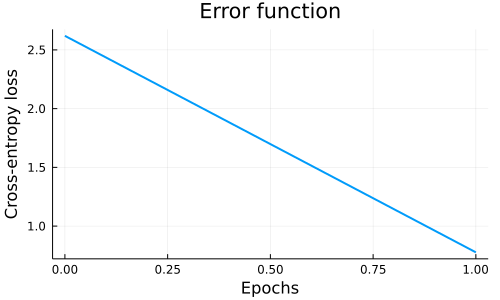

In [21]:
losses = rp.neural_network_classifier.training_losses
epochs = pipe.neural_network_classifier.epochs
plot(0:epochs, losses, title="Error function", size=(500,300), linewidth=2, legend=false)
xlabel!("Epochs")
ylabel!("Cross-entropy loss")

Testing

In [22]:
X_ts, y_ts = preprocess(testX, testY);
ŷ = predict_mode(mach, X_ts)
printMetrics(ŷ, y_ts)

10×10 Matrix{Int64}:
 1715     0    14     9     3    31    12     7    10    11
    0  1957    20     5     3     6     2    14    38     4
    5    14  1607    55    12    10     8    25    28     1
    2     4    23  1585     2    55     0    10    55    26
    6     3    19     0  1640    27    14    21    12   100
   18     9    10    96     3  1397    30     2    81    18
   12     2    26     7    21    29  1699     0    21     0
    5     6    27    35     6    11     3  1766    10    74
   13    24    37    31    12    43     7     3  1470    11
    1     4     4    16    51    17     0    31    30  1540

accuracy: 0.91
f1-score: 

0.908


Validation

In [ ]:
X_v, y_v = preprocess(validationX, validationY)
ŷ = predict_mode(mach, X_v)
printMetrics(ŷ, y_v)